## Novel Molecule Generation using Bidirectional-Recurrent Neural Networks with Attention Applied to Simplified Molecular Input Line Entry Sysem (SMILES)

## Visualize Molecules from SMILES

author: anthony j. vasquez
email: vanthony715@gmail.com / avasque1@jh.edu

In [1]:
import time
from datetime import datetime
t0 = time.time()

import sys
sys.path.append('./data/')

import gc
gc.collect()

import os
##had a hard time with this setting on windows os using spyder and jypyter
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import warnings
warnings.filterwarnings("ignore")

import platform
print("Operating System: ", platform.system())
print("Machine Type:: ", platform.machine())

import multiprocessing as mp
max_processors = mp.cpu_count()
print('Processor Count: ', max_processors, '\n')

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem.Descriptors import CalcMolDescriptors
from rdkit.Chem.rdMolDescriptors import GetHashedMorganFingerprint

from net import *
from utils import *
from custom_dataset import *

##OS
LINUX = True
N_PROCESSORS = max_processors - 2

Operating System:  Linux
Machine Type::  x86_64
Processor Count:  24 



In [3]:
%%time

### Import the data
data_file = pd.read_csv('../data/Zinc_all_smiles_data.txt', header = None)
data_file.columns = ['smiles']
smilesList = data_file['smiles'].tolist()
print('Len all smiles: ', len(smilesList))

print('\n')

Len all smiles:  249456


CPU times: user 172 ms, sys: 29.3 ms, total: 201 ms
Wall time: 213 ms


In [9]:
##get smalles SMILES string
lengths = {'mol': [], 'len': []}
for i, val in enumerate(smilesList):
    lengths['mol'].append(val)
    lengths['len'].append(len(val))
len_df = pd.DataFrame(lengths)
len_df = len_df.sort_values(by='len')
len_df.head()

,mol,len
99151,Cn1nccc1I,9
44328,C=C(Br)CON,10
132728,Cc1scnc1Br,10
223007,C/C(I)=C/CI,11
120462,C1CSCCSCCS1,11


In [10]:
len_df.tail()

,mol,len
104981,C=C1CC[C@@H]2[C@@](C)(CO[C@H]3O[C@@H](CO)[C@@H...,106
95168,C[C@@H]1C[C@@H]2[C@@H]3C[C@H](F)C4=CC(=O)C=C[C...,108
134990,COc1cccc(N2C(=O)[C@@H]3[C@H](C2=O)[C@H]2[C@@H]...,108
233038,C[C@]12C=CC(=O)C=C1CC[C@@H]1[C@@H]2CC[C@@]2(C)...,109
234299,CC(=O)O[C@H]1CC[C@@]2(C)[C@H](C1)C(=O)C[C@H]1[...,120


### Visualize Extremely Easy Cases

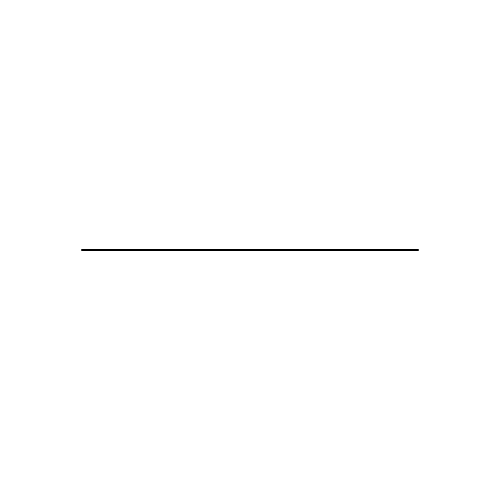

In [24]:
##plot a single example
img = plot_single_mol('CC')
img

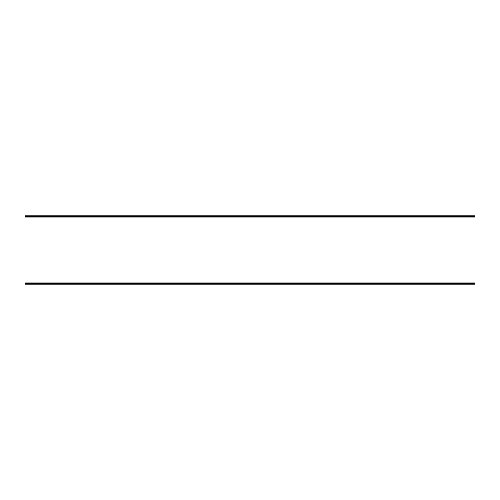

In [25]:
##plot a single example
img = plot_single_mol('C=C')
img

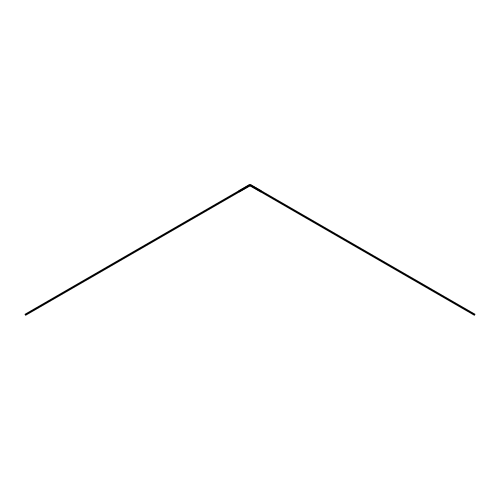

In [26]:
##plot a single example
img = plot_single_mol('C(C)C')
img

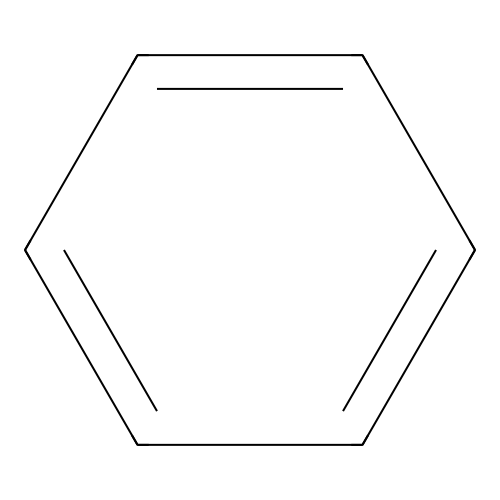

In [27]:
##plot a single example
img = plot_single_mol('c1ccccc1')
img

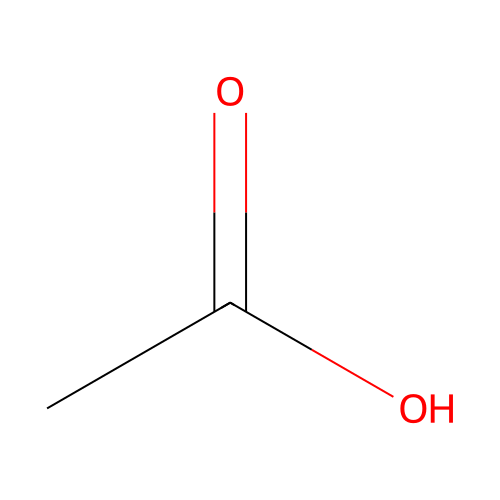

In [28]:
##plot a single example
img = plot_single_mol('CC(=O)O')
img

### Visualize Simple Molecule


 Cn1nccc1I 

CPU times: user 10 ms, sys: 7 µs, total: 10 ms
Wall time: 10 ms


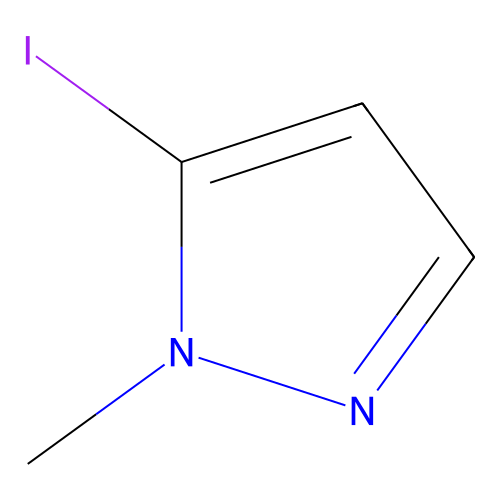

In [16]:
%%time

##get molecule
molecule = len_df['mol'].values[0]
print('\n', molecule, '\n')

##plot a single example
img = plot_single_mol(molecule)

img

### Visualize Mid Complexity


 CCc1ccc(C[C@@]2(c3ccc(Br)cc3)NC(N)=NC2=O)cc1 

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 11.8 ms


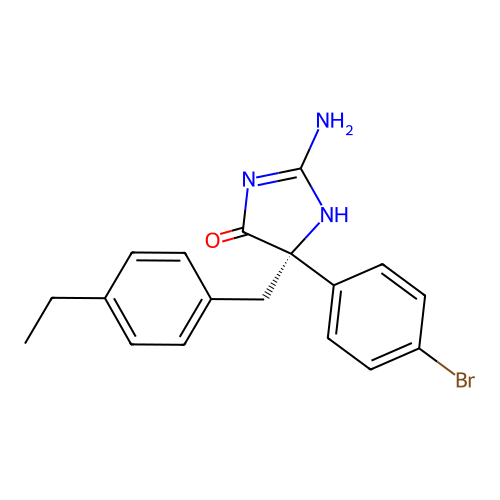

In [17]:
%%time

##get molecule
molecule = len_df['mol'].values[len(len_df)//2]
print('\n', molecule, '\n')

##plot a single example
img = plot_single_mol(molecule)

img

### Visualize Most Complex Molecule


 CC(=O)O[C@H]1CC[C@@]2(C)[C@H](C1)C(=O)C[C@H]1[C@@H]3CC[C@@H]4[C@@H](C[NH+]5C[C@@H](C)CC[C@H]5[C@@]4(C)O)[C@@H]3C[C@@H]12 

CPU times: user 12.2 ms, sys: 0 ns, total: 12.2 ms
Wall time: 12.2 ms


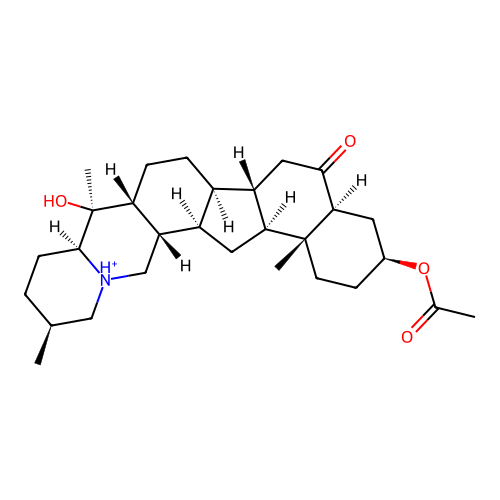

In [18]:
%%time

##get molecule
molecule = len_df['mol'].values[-1]
print('\n', molecule, '\n')

##plot a single example
img = plot_single_mol(molecule)

img

### Generate Random Molecules from Dataset

Random Indices:  [103843 141681  24531 169766 126354 119321 170848 192223 116305  16736
  44722  34114 145119 134935  75826   4235 117826  59187 150926  95109]
CPU times: user 84.1 ms, sys: 0 ns, total: 84.1 ms
Wall time: 83.7 ms


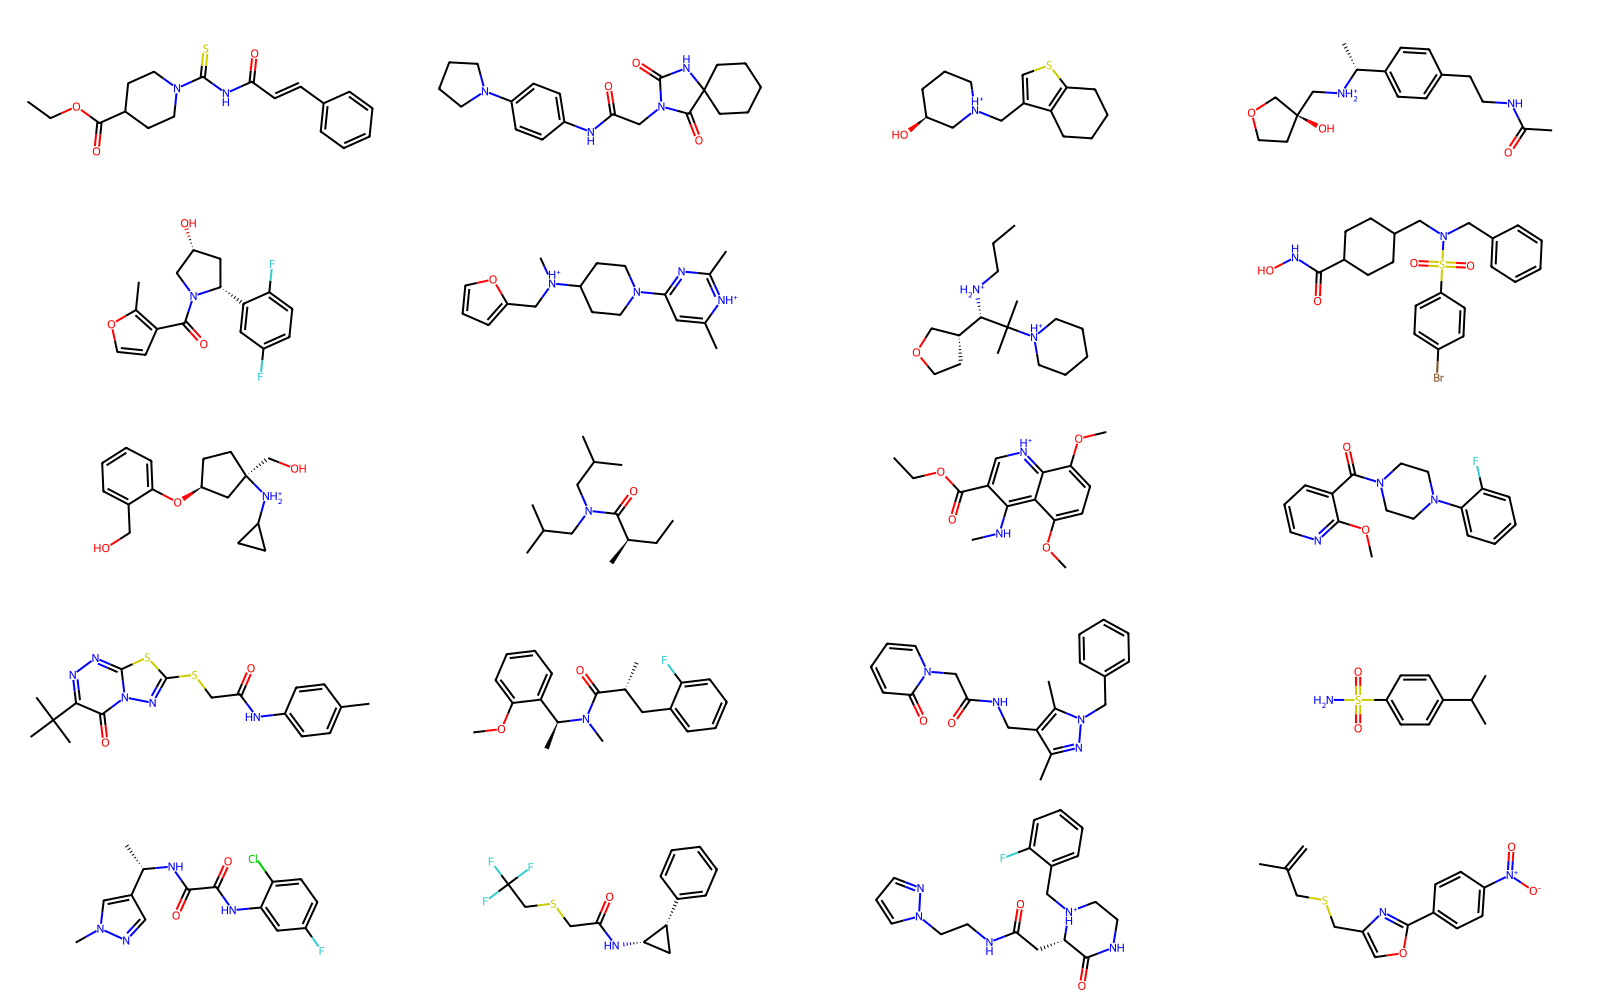

In [20]:
%%time

##range
min_val, max_val = 0, len(len_df)
num_to_gen = 20
rand_idxs = np.random.randint(min_val, max_val, num_to_gen)
print('Random Indices: ', rand_idxs)

##get random molecules
rand_samples = list(len_df.iloc[rand_idxs]['mol'].values)

##plot on grid
grid_img = plot_smiles_grid(smiles_list=rand_samples)
grid_img

### Tokenize Molecules

In [30]:
%%time

# Example usage:
vocab = build_vocabulary(smilesList)
max_length = max(len(tokenize_smiles(smiles)) for smiles in smilesList)

print('Max_length: ', max_length)
print('Length Vocab: ', len(vocab))
print('\n')

Max_length:  27
Length Vocab:  254593


CPU times: user 688 ms, sys: 308 µs, total: 689 ms
Wall time: 688 ms


In [34]:
for i, smiles in enumerate(smilesList):
    print(tokenize_smiles(smiles))
    if i >= 20: 
        break

['CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1']
['C', '[C@@H]', '1CC(Nc2cncc(-c3nncn3C)c2)C', '[C@@H]', '(C)C1']
['N#Cc1ccc(-c2ccc(O', '[C@@H]', '(C(=O)N3CCCC3)c3ccccc3)cc2)cc1']
['CCOC(=O)', '[C@@H]', '1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c2CCCCC3)C1']
['N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C(', '[O-]', ')', '[C@H]', '(C#N)C12CCCCC2']
['CC', '[NH+]', '(CC)', '[C@]', '(C)(CC)', '[C@H]', '(O)c1cscc1Br']
['COc1ccc(C(=O)N(C)', '[C@@H]', '(C)C/C(N)=N/O)cc1O']
['O=C(Nc1nc', '[nH]', 'n1)c1cccnc1Nc1cccc(F)c1']
['Cc1c(/C=N/c2cc(Br)ccn2)c(O)n2c(nc3ccccc32)c1C#N']
['C', '[C@@H]', '1CN(C(=O)c2cc(Br)cn2C)CC', '[C@H]', '1', '[NH3+]']
['CCOc1ccc(OCC)c(', '[C@H]', '2C(C#N)=C(N)N(c3ccccc3C(F)(F)F)C3=C2C(=O)CCC3)c1']
['Cc1ccc2nc(S', '[C@H]', '(C)C(=O)NC3CCC(C)CC3)n(C)c(=O)c2c1']
['O=C(N1CCc2c(F)ccc(F)c2C1)C1(O)Cc2ccccc2C1']
['Cc1ccccc1C(=O)N1CCC2(CC1)C', '[C@H]', '(c1ccccc1)C(=O)N2C']
['CCCc1cc(NC(=O)CN2C(=O)NC3(CCC(C)CC3)C2=O)n(C)n1']
['CC(C)Cc1nc(SCC(=O)NC', '[C@@H]', '2CCCO2)c2c(=O)n(C)c(=O)n(C)c2n1']
['Cc1ccc(CNC(

In [13]:
##clean and time
gc.collect()
torch.cuda.empty_cache()
tf = time.time()
print('Total Runtime: ', np.round(tf - t0, 3))

Total Runtime:  31.138
